In [1]:
import os
os.environ['THEANO_FLAGS']='device=gpu'

import subprocess
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd

#go to working directory
#work_dir='/nagyvinyok/adat84/sotejedlik/ribli/mhc'
work_dir='/mnt/Data1/ribli/mhc/'
subprocess.call(['mkdir',work_dir])
os.chdir(work_dir)

In [2]:
#load train data
dataf='benchmark_mhci_reliability/binding/bd2013.1/bdata.20130222.mhci.public.1.txt'
data=pd.read_csv(dataf,sep='\t')
data=data[(data.species=='human') &(data.inequality=='=') ][['mhc','sequence','meas','peptide_length']]
len(data)

83751

### Use the most simplistic one-hot encoding

In [3]:
#make peptids 'equal'
maxlen=max(map(len,data.sequence.values))
data['sequence']=[x.zfill(maxlen) for x in data.sequence.values]

#tools
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
lb = preprocessing.LabelBinarizer()

#encode hla type with one hot binary vectors
x_hla_0=le.fit_transform( data['mhc'] )
x_hla=lb.fit_transform( x_hla_0)

#encode amino acids with one hot binrary vectors
x_seq=np.array([map(ord,x) for x in data.sequence])
lb.fit(x_seq.flatten())
x_seq_b=np.column_stack([lb.transform(x_seq[:,i]) for i in range(x_seq.shape[1])])

#stack the two together
x=np.column_stack([x_hla,x_seq_b,data.peptide_length.values])

In [4]:
#predict log10 value
y=np.log10(data.meas)

In [5]:
#make train, test and validation split
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [10]:
#create a very simple deepish model
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping

model = Sequential()
model.add(Dense(1024, input_dim=X_train.shape[1],activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [11]:
validation_split=0.1
patience=1
nb_epoch=100

#callbacks
best_model=ModelCheckpoint('best_model',save_best_only=True,verbose=1)
early_stop=EarlyStopping(patience=patience,verbose=1)


#train it
callb_hist=model.fit(X_train,y_train,nb_epoch = nb_epoch,verbose=1,
                        validation_split=validation_split,
                        callbacks=[best_model,early_stop])
    
#predict
model.load_weights('best_model')
y_pred_test=model.predict(X_test).ravel()

Train on 67837 samples, validate on 7538 samples
Epoch 1/100
67837/67837 [==============================] - 3s - loss: 1.3909 - val_loss: 1.1188
Epoch 00000: val_loss improved from inf to 1.11881, saving model to best_model
Epoch 2/100
67837/67837 [==============================] - 3s - loss: 0.8963 - val_loss: 0.8657
Epoch 00001: val_loss improved from 1.11881 to 0.86574, saving model to best_model
Epoch 3/100
67837/67837 [==============================] - 3s - loss: 0.6863 - val_loss: 0.7874
Epoch 00002: val_loss improved from 0.86574 to 0.78737, saving model to best_model
Epoch 4/100
67837/67837 [==============================] - 3s - loss: 0.5700 - val_loss: 0.8380
Epoch 00003: val_loss did not improve
Epoch 5/100
67837/67837 [==============================] - 3s - loss: 0.4872 - val_loss: 0.7526
Epoch 00004: val_loss improved from 0.78737 to 0.75261, saving model to best_model
Epoch 6/100
67837/67837 [==============================] - 3s - loss: 0.4226 - val_loss: 0.7724
Epoch 000

Correlation: (0.76739175877329513, 0.0)


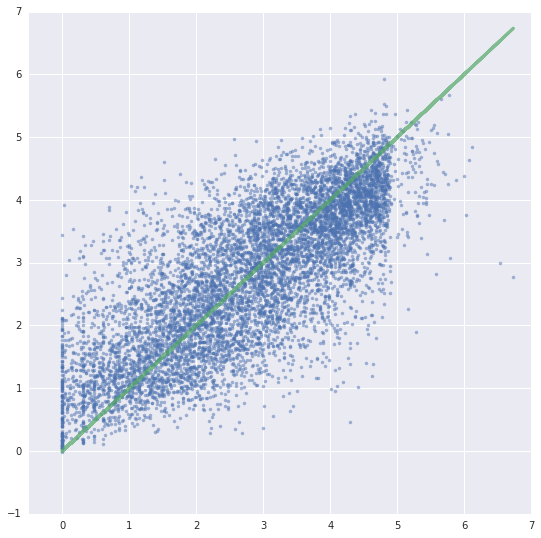

In [12]:
# check correlation
plt.figure(figsize=(9,9))
plt.plot(y_test,y_pred_test,'.',alpha=0.5)
plt.plot(y_test,y_test,lw=3,alpha=0.7)
plt.xlim(xmin=-0.5)
from scipy.stats import pearsonr
print 'Correlation:',pearsonr(y_test,y_pred_test)

### Error depending on the length of peptid

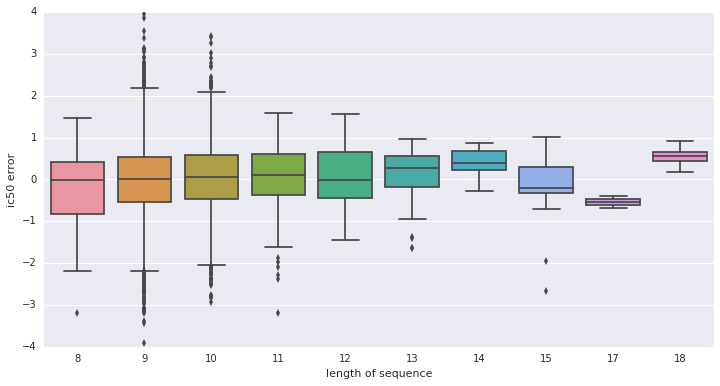

In [13]:
leng=X_test[:,-1]
plt.figure(figsize=(12,6))
sns.boxplot(leng,y_test-y_pred_test)
plt.xlabel('length of sequence')
dump=plt.ylabel('ic50 error')